In [ ]:
import torch
import secrets
import random as rand
import bittensor as bt
from typing import Generator
from collections import defaultdict
import matplotlib.pyplot as plt


# Simulation params
NUMBER_OF_NEURONS_TO_SCORE = 256

# Weights for SN27
SUCCESS_WEIGHT = 1
DIFFICULTY_WEIGHT = 1
TIME_ELAPSED_WEIGHT = 0.3
FAILED_PENALTY_WEIGHT = 0.4
ALLOCATION_WEIGHT = 0.21

# Misc params for SN27 scoring
FAILED_PENALTY_EXP = 1.5
POW_TIMEOUT = 30
POW_MIN_DIFFICULTY = 7
POW_MAX_DIFFICULTY = 12


class Compute:
    def __init__(self):
        self.pow_timeout = POW_TIMEOUT
        self.pow_min_difficulty = POW_MIN_DIFFICULTY
        self.pow_max_difficulty = POW_MAX_DIFFICULTY


compute = Compute()

In [ ]:
class SN27InputData(defaultdict):
    response: dict
    hotkey: str
    allocated_hotkeys: list[str]
    penalized_hotkeys: list[str]
    validator_hotkeys: list[str]

    def __init__(
        self, response, hotkey, allocated_hotkeys, penalized_hotkeys, validator_hotkeys
    ):
        super().__init__()
        self.response = response
        self.hotkey = hotkey
        self.allocated_hotkeys = allocated_hotkeys
        self.penalized_hotkeys = penalized_hotkeys
        self.validator_hotkeys = validator_hotkeys

    def to_original_input(self):
        return {
            "response": self.response,
            "hotkey": self.hotkey,
            "allocated_hotkeys": self.allocated_hotkeys,
            "penalized_hotkeys": self.penalized_hotkeys,
            "validator_hotkeys": self.validator_hotkeys,
        }

    def to_modified_input(self):
        return {
            "challenge_attempts": torch.tensor(
                self.response.get("challenge_attempts", 1), dtype=torch.int32
            ),
            "challenge_successes": torch.tensor(
                self.response.get("challenge_successes", 0), dtype=torch.int32
            ),
            "last_20_challenge_failed": torch.tensor(
                self.response.get("last_20_challenge_failed", 0), dtype=torch.int32
            ),
            "challenge_elapsed_time_avg": torch.tensor(
                self.response.get("challenge_elapsed_time_avg", compute.pow_timeout),
                dtype=torch.float32,
            ),
            "last_20_difficulty_avg": torch.tensor(
                self.response.get("last_20_difficulty_avg", compute.pow_min_difficulty),
                dtype=torch.float32,
            ),
            "has_docker": torch.tensor(
                self.response.get("has_docker", False), dtype=torch.bool
            ),
            "uid": torch.tensor(hotkey_to_uid[self.hotkey], dtype=torch.int16),
            "allocated_uids": torch.tensor(
                [hotkey_to_uid[h] for h in self.allocated_hotkeys]
                + [-1] * (NUMBER_OF_NEURONS_TO_SCORE - len(self.allocated_hotkeys)),
                dtype=torch.int32,
            ),
            "penalized_uids": torch.tensor(
                [hotkey_to_uid[h] for h in self.penalized_hotkeys]
                + [-1] * (NUMBER_OF_NEURONS_TO_SCORE - len(self.penalized_hotkeys)),
                dtype=torch.int32,
            ),
            "validator_uids": torch.tensor(
                [hotkey_to_uid[h] for h in self.validator_hotkeys]
                + [-1] * (NUMBER_OF_NEURONS_TO_SCORE - len(self.validator_hotkeys)),
                dtype=torch.int32,
            ),
            "success_weight": torch.tensor(SUCCESS_WEIGHT, dtype=torch.float32),
            "difficulty_weight": torch.tensor(DIFFICULTY_WEIGHT, dtype=torch.float32),
            "time_elapsed_weight": torch.tensor(
                TIME_ELAPSED_WEIGHT, dtype=torch.float32
            ),
            "failed_penalty_weight": torch.tensor(
                FAILED_PENALTY_WEIGHT, dtype=torch.float32
            ),
            "allocation_weight": torch.tensor(ALLOCATION_WEIGHT, dtype=torch.float32),
            "pow_timeout": torch.tensor(compute.pow_timeout, dtype=torch.float32),
            "pow_min_difficulty": torch.tensor(
                compute.pow_min_difficulty, dtype=torch.float32
            ),
            "pow_max_difficulty": torch.tensor(
                compute.pow_max_difficulty, dtype=torch.float32
            ),
            "nonce": torch.tensor(secrets.randbits(32), dtype=torch.int64),
        }

    def to_circuit_input(self):
        modified_input = self.to_modified_input()
        return {
            k: v.item() if isinstance(v, torch.Tensor) else v
            for k, v in modified_input.items()
        }


all_hotkeys = [
    bt.Keypair.create_from_mnemonic(bt.Keypair.generate_mnemonic()).ss58_address
    for _ in range(NUMBER_OF_NEURONS_TO_SCORE)
]

hotkey_to_uid = {hotkey: i for i, hotkey in enumerate(all_hotkeys)}

allocated_hotkeys = []
penalized_hotkeys = []
validator_hotkeys = []

single_membership = all_hotkeys[:30]
dual_membership = all_hotkeys[30:45]
triple_membership = all_hotkeys[45:55]

allocated_hotkeys.extend(single_membership[:10])
allocated_hotkeys.extend(dual_membership[:8])
allocated_hotkeys.extend(triple_membership)

penalized_hotkeys.extend(single_membership[10:20])
penalized_hotkeys.extend(dual_membership[7:])
penalized_hotkeys.extend(triple_membership)

validator_hotkeys.extend(single_membership[20:])
validator_hotkeys.extend(dual_membership[:7])
validator_hotkeys.extend(triple_membership)


def generate_input_set() -> Generator[SN27InputData, None, None]:
    for hotkey in all_hotkeys:
        attempts = rand.randint(5, 10)
        successes = min(attempts, rand.randint(4, 8))

        input_data = SN27InputData(
            response={
                "challenge_attempts": attempts,
                "challenge_successes": successes,
                "last_20_challenge_failed": rand.randint(0, 20),
                "challenge_elapsed_time_avg": 4.0 + rand.random() * 4.0,
                "last_20_difficulty_avg": compute.pow_min_difficulty
                + rand.random()
                * (compute.pow_max_difficulty - compute.pow_min_difficulty),
                "has_docker": rand.random() < 0.5,
            },
            hotkey=hotkey,
            allocated_hotkeys=allocated_hotkeys,
            penalized_hotkeys=penalized_hotkeys,
            validator_hotkeys=validator_hotkeys,
        )
        yield input_data

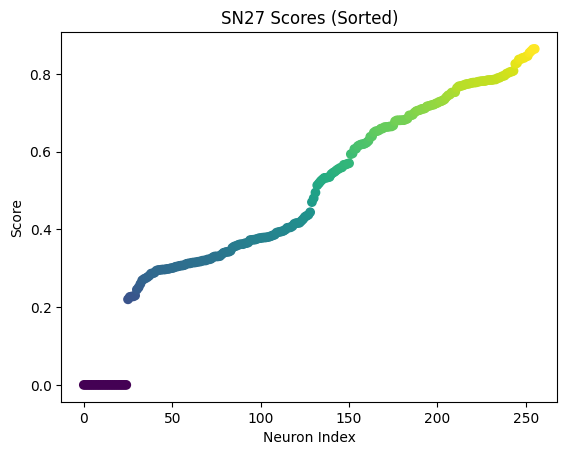

In [ ]:

def normalize(val, min_value, max_value):
    return (val - min_value) / (max_value - min_value)


def prevent_none(val):
    return 0 if not val else val


def percent(a, b):
    if b == 0:
        return 0
    return (a / b) * 100


def percent_yield(a, b):
    if a == 0:
        return 100
    return ((b - a) / b) * 100


def calc_score(
    response,
    hotkey,
    allocated_hotkeys,
    penalized_hotkeys,
    validator_hotkeys,
    mock=False,
):
    """
    Method to calculate the score attributed to this miner dual uid - hotkey
    :param response:
    {
        'challenge_attempts': 7,
        'challenge_successes': 6,
        'challenge_failed': 0,
        'challenge_elapsed_time_avg': 5.804196675618489,
        'challenge_difficulty_avg': 2.0,
        'has_docker': True,
    }
    challenge_failed is batched over the last 10 challenges only
    :param hotkey:
    :param mock: During testing phase
    :return:
    """
    try:
        challenge_attempts = prevent_none(response.get("challenge_attempts", 1))
        challenge_successes = prevent_none(response.get("challenge_successes", 0))
        last_20_challenge_failed = prevent_none(
            response.get("last_20_challenge_failed", 0)
        )
        challenge_elapsed_time_avg = prevent_none(
            response.get("challenge_elapsed_time_avg", compute.pow_timeout)
        )
        challenge_difficulty_avg = prevent_none(
            response.get("last_20_difficulty_avg", compute.pow_min_difficulty)
        )
        has_docker = response.get("has_docker", False)

        # Define base weights for the PoW
        success_weight = 1
        difficulty_weight = 1
        time_elapsed_weight = 0.3
        failed_penalty_weight = 0.4
        allocation_weight = 0.21

        # Just in case but in theory, it is not possible to fake the difficulty as it is sent by the validator
        # Same occurs for the time, it's calculated by the validator so miners cannot fake it

        # Difficulty, score range: [0,100] * difficulty_weight
        difficulty_val = max(
            min(challenge_difficulty_avg, compute.pow_max_difficulty),
            compute.pow_min_difficulty,
        )
        difficulty_modifier = percent(difficulty_val, compute.pow_max_difficulty)

        difficulty = difficulty_modifier * difficulty_weight

        # Success ratio, score range: [0,100] * success_weight
        successes_ratio = percent(challenge_successes, challenge_attempts)
        successes = successes_ratio * success_weight

        # Time elapsed, score range: [0,100] * time_elapsed_weight
        # Modifier for elapsed time effect
        time_elapsed_modifier = percent_yield(
            challenge_elapsed_time_avg, compute.pow_timeout
        )
        time_elapsed = time_elapsed_modifier * time_elapsed_weight

        # Failed penalty, score range [0,100] * failed_penalty_weight
        # Failed penalty has exponential weigt, the higher the failure rate, the higher the penalty
        failed_penalty_exp = 1.5
        last_20_challenge_failed_modifier = percent(
            last_20_challenge_failed, 20
        )  # Normalize with defined limits (0,100)
        failed_penalty = (
            failed_penalty_weight
            * (last_20_challenge_failed_modifier / 100) ** failed_penalty_exp
            * 100
        )

        # Allocation, score range [0, 100] * allocation_weight
        # The score for allocation is proportional to the average difficulty reached before allocation
        allocation_score = difficulty_modifier * allocation_weight
        allocation_status = hotkey in allocated_hotkeys

        # Calculate the score
        max_score_challenge = 100 * (
            success_weight + difficulty_weight + time_elapsed_weight
        )
        max_score_allocation = 100 * allocation_weight
        max_score = max_score_challenge + max_score_allocation
        final_score = difficulty + successes + time_elapsed - failed_penalty

        # Docker and specs penalty
        penalty = not (has_docker)

        if allocation_status:
            final_score = (
                max_score_challenge * (1 - allocation_weight) + allocation_score
            )
        else:
            final_score = difficulty + successes + time_elapsed - failed_penalty
            if penalty:
                final_score = final_score / 2

        if (
            last_20_challenge_failed >= 19 or challenge_successes == 0
        ) and not allocation_status:
            return 0

        # Penalize miners if their hotkey is in the penalized_hotkeys list
        if hotkey in penalized_hotkeys:
            # Calculate the penalty factor based on the proportion of penalized hotkeys
            penalty_count = penalized_hotkeys.count(hotkey)
            half_validators = len(validator_hotkeys) / 2

            # If penalty count equals or exceeds half of the validators, set score to 0
            if penalty_count >= half_validators:
                final_score = 0
            else:
                penalty_multiplier = max(1 - (penalty_count / half_validators), 0)
                final_score *= penalty_multiplier

        # Final score is > 0
        final_score = max(0, final_score)

        # Normalize the score
        normalized_score = normalize(final_score, 0, max_score)
        return normalized_score
    except Exception as e:
        bt.logging.error(
            f"An error occurred while calculating score for the following hotkey - {hotkey}: {e}"
        )
        return 0


inputs: list[SN27InputData] = list(generate_input_set())

original_scores = [calc_score(**input_data.to_original_input()) for input_data in inputs]

sorted_scores = sorted(original_scores)
plt.scatter(range(len(sorted_scores)), sorted_scores, c=sorted_scores, cmap="viridis")
plt.xlabel("Neuron Index")
plt.ylabel("Score")
plt.title("SN27 Scores (Sorted)")
plt.show()

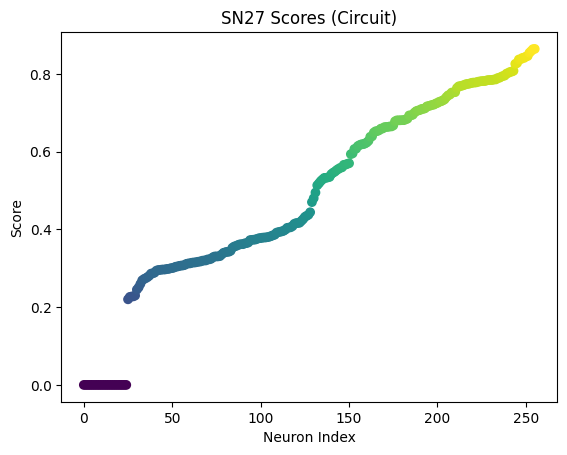

In [ ]:
class Circuit(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.zero = torch.tensor(0.0)
        self.one = torch.tensor(1.0)
        self.two = torch.tensor(2.0)
        self.one_hundred = torch.tensor(100.0)
        self.twenty = torch.tensor(20.0)
        self.nineteen = torch.tensor(19.0)
        self.failed_penalty_exp = torch.tensor(1.5)

    def forward(
        self,
        challenge_attempts,
        challenge_successes,
        last_20_challenge_failed,
        challenge_elapsed_time_avg,
        last_20_difficulty_avg,
        has_docker,
        uid,
        allocated_uids,
        penalized_uids,
        validator_uids,
        success_weight,
        difficulty_weight,
        time_elapsed_weight,
        failed_penalty_weight,
        allocation_weight,
        pow_timeout,
        pow_min_difficulty,
        pow_max_difficulty,
        nonce,
    ):
        difficulty_val = torch.clamp(last_20_difficulty_avg, pow_min_difficulty, pow_max_difficulty)
        difficulty_modifier = (difficulty_val / pow_max_difficulty) * self.one_hundred
        difficulty = difficulty_modifier * difficulty_weight

        successes_ratio = (challenge_successes / challenge_attempts) * self.one_hundred
        successes = successes_ratio * success_weight

        time_elapsed_modifier = ((pow_timeout - challenge_elapsed_time_avg) / pow_timeout) * self.one_hundred
        time_elapsed = time_elapsed_modifier * time_elapsed_weight

        last_20_challenge_failed_modifier = (last_20_challenge_failed / self.twenty) * self.one_hundred
        failed_penalty = failed_penalty_weight * torch.pow(last_20_challenge_failed_modifier / self.one_hundred, self.failed_penalty_exp) * self.one_hundred

        allocation_score = difficulty_modifier * allocation_weight
        allocation_status = torch.any(allocated_uids == uid.unsqueeze(1), dim=1)

        max_score_challenge = self.one_hundred * (success_weight + difficulty_weight + time_elapsed_weight)
        max_score = max_score_challenge + (self.one_hundred * allocation_weight)

        final_score = difficulty + successes + time_elapsed - failed_penalty

        penalty = ~has_docker.bool()
        final_score = torch.where(penalty, final_score / self.two, final_score)

        allocated_score = max_score_challenge * (self.one - allocation_weight) + allocation_score
        final_score = torch.where(allocation_status, allocated_score, final_score)

        zero_condition = (last_20_challenge_failed >= self.nineteen) | (challenge_successes == self.zero)
        final_score = torch.where(zero_condition & ~allocation_status, self.zero, final_score)

        penalty_counts = torch.sum(penalized_uids == uid.unsqueeze(1), dim=1)
        half_validators = torch.sum(validator_uids >= self.zero) / self.two

        penalty_condition = penalty_counts >= half_validators
        penalty_multiplier = torch.clamp(self.one - (penalty_counts / half_validators), min=self.zero)

        final_score = torch.where(penalty_condition, self.zero, final_score * penalty_multiplier)

        final_score = torch.clamp(final_score, min=self.zero)
        normalized_score = (final_score - self.zero) / (max_score - self.zero)

        return normalized_score, nonce


combined_inputs = {}
for key in inputs[0].to_modified_input().keys():
    values = [data.to_modified_input()[key] for data in inputs]
    combined_inputs[key] = torch.stack(values)
combined_inputs["allocated_uids"] = inputs[0].to_modified_input()["allocated_uids"]
combined_inputs["penalized_uids"] = inputs[0].to_modified_input()["penalized_uids"]
combined_inputs["validator_uids"] = inputs[0].to_modified_input()["validator_uids"]

circuit = Circuit()
modified_scores, nonce = circuit(**combined_inputs)

sorted_circuit_scores = sorted(modified_scores)
plt.scatter(range(len(sorted_circuit_scores)), sorted_circuit_scores, c=sorted_circuit_scores, cmap="viridis")
plt.xlabel("Neuron Index")
plt.ylabel("Score")
plt.title("SN27 Scores (Circuit)")
plt.show()

In [ ]:
import os
import json
import onnxruntime as ort
import onnx
import ezkl

def prepare_json_data(inputs):
    return {
        "input_data": [
            inputs["challenge_attempts"].tolist(),
            inputs["challenge_successes"].tolist(),
            inputs["last_20_challenge_failed"].tolist(),
            inputs["challenge_elapsed_time_avg"].tolist(),
            inputs["last_20_difficulty_avg"].tolist(),
            inputs["has_docker"].tolist(),
            inputs["uid"].tolist(),
            inputs["allocated_uids"].tolist(),
            inputs["penalized_uids"].tolist(),
            inputs["validator_uids"].tolist(),
            [inputs["success_weight"].tolist()[0]],
            [inputs["difficulty_weight"].tolist()[0]],
            [inputs["time_elapsed_weight"].tolist()[0]],
            [inputs["failed_penalty_weight"].tolist()[0]],
            [inputs["allocation_weight"].tolist()[0]],
            [inputs["pow_timeout"].tolist()[0]],
            [inputs["pow_min_difficulty"].tolist()[0]],
            [inputs["pow_max_difficulty"].tolist()[0]],
            [inputs["nonce"].tolist()[0]]
            ]
    }

input_data = prepare_json_data(combined_inputs)
calibration_data = prepare_json_data(combined_inputs)

with open("input.json", "w") as f:
    json.dump(input_data, f)

with open("calibration.json", "w") as f:
    json.dump(calibration_data, f)

circuit.eval()

input_names = [
    "challenge_attempts", "challenge_successes", "last_20_challenge_failed",
    "challenge_elapsed_time_avg", "last_20_difficulty_avg", "has_docker", "uid",
    "allocated_uids", "penalized_uids", "validator_uids", "success_weight",
    "difficulty_weight", "time_elapsed_weight", "failed_penalty_weight",
    "allocation_weight", "pow_timeout", "pow_min_difficulty", "pow_max_difficulty", "nonce"
]

torch.onnx.export(
    circuit,
    combined_inputs,
    "network.onnx",
    input_names=input_names,
    output_names=["score", "nonce_out"],
    do_constant_folding=True,
    dynamic_axes={
        "success_weight": {0: "batch_size"},
        "difficulty_weight": {0: "batch_size"},
        "time_elapsed_weight": {0: "batch_size"},
        "failed_penalty_weight": {0: "batch_size"},
        "allocation_weight": {0: "batch_size"},
        "pow_timeout": {0: "batch_size"},
        "pow_min_difficulty": {0: "batch_size"},
        "pow_max_difficulty": {0: "batch_size"},
        "nonce": {0: "batch_size"},
        "nonce_out": {0: "batch_size"}
    }
)

def prepare_onnx_inputs(inputs):
    return {name: inputs[name].numpy() for name in input_names}

onnx_inputs = prepare_onnx_inputs(combined_inputs)

model = onnx.load("network.onnx")

try:
    onnx.checker.check_model(model, full_check=True)
except onnx.checker.ValidationError as e:
    print(f"The model is invalid: {e}")

session = ort.InferenceSession("network.onnx")
onnx_scores = list(session.run(None, onnx_inputs)[0])

py_run_args = ezkl.PyRunArgs()
py_run_args.input_visibility = "public"
py_run_args.param_visibility = "fixed"
py_run_args.decomp_legs = 3
try:
    ezkl.gen_settings(py_run_args=py_run_args)
    ezkl.calibrate_settings(target="accuracy", scales=[19])
except:
    pass
for logrows in range(1, 26):
    if not os.path.exists(os.path.expanduser(f"~/.ezkl/srs/kzg{logrows}.srs")):
        print(f"Getting SRS for logrows {logrows}")
        await ezkl.get_srs(logrows=logrows, commitment=ezkl.PyCommitments.KZG)
ezkl.compile_circuit()
ezkl.setup()
ezkl.gen_witness()
ezkl.prove()
# ezkl.verify()

with open("witness.json", "r") as f:
    witness = json.load(f)

zk_scores = [torch.tensor(float(x), dtype=torch.float32) for x in witness["pretty_elements"]["rescaled_outputs"][0]]

sorted_zk_scores = sorted(zk_scores)
plt.scatter(range(len(sorted_zk_scores)), sorted_zk_scores, c=sorted_zk_scores, cmap="viridis")
plt.xlabel("Neuron Index")
plt.ylabel("Score")
plt.title("SN27 Scores (ZK)")
plt.show()

low scale values (<8) may impact precision
[tensor] decomposition error: integer 8073490220331156166613376437531443200 is too large to be represented by base 16384 and n 3
[halo2] An out-of-bounds index was passed to the backend
[halo2] General synthesis error
[halo2] General synthesis error
forward pass failed: "failed to forward: [halo2] General synthesis error"


 <------------- Numerical Fidelity Report (input_scale: 19, param_scale: 19, scale_input_multiplier: 1) ------------->

+----------------+----------------+-----------+----------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error     | median_error   | max_error | min_error      | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+----------------+----------------+-----------+----------------+----------------+------------------+-----------

RuntimeError: Failed to run prove: [pfsys] [halo2] General synthesis error

                                                                                  Score Comparison                                                                                  
┏━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃     ┃ Challenge ┃ Challenge ┃   Last 20 ┃  Elapsed ┃ Difficul… ┃   Has    ┃           ┃          ┃  Original ┃ Modified ┃          ┃  Modified ┃          ┃      ONNX ┃     ONNX ┃
┃ UID ┃  Attempts ┃ Successes ┃    Failed ┃ Time Avg ┃       Avg ┃  Docker  ┃ Allocated ┃ Penaliz… ┃     Score ┃    Score ┃ ZK Score ┃      Diff ┃  ZK Diff ┃     Score ┃     Diff ┃
┡━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│   0 │         6 │         6 │         5 │   7.9569 │    7.2584 │    ✓     │     ✓     │    ✗     │  0.774510 │ 0.774511 │ 0.774586 │ +0.000000 │ +0.0000… │  0.774511 │ +0.0000… │
│   1 │        10 │         8 │         9 │   5.9712 │    8.5602 │    ✓     │     ✓     │    ✗     │  0.783587 │ 0.783587 │ 0.783665 │ +0.000000 │ +0.0000… │  0.783587 │ +0.0000… │
│   2 │         7 │         7 │        12 │   4.9885 │    9.4569 │    ✗     │     ✓     │    ✗     │  0.789839 │ 0.789839 │ 0.789917 │ +0.000000 │ +0.0000… │  0.789839 │ +0.0000… │
│   3 │         8 │         5 │        20 │   4.1498 │    8.6155 │    ✓     │     ✓     │    ✗     │  0.783972 │ 0.783972 │ 0.784050 │ +0.000000 │ +0.0000… │  0.783972 │ +0.0000… │
│   4 │         7 │         4 │         4 │   5.6360 │    7.8664 │    ✓     │     ✓     │    ✗     │  0.778750 │ 0.778750 │ 0.778826 │ +0.000000 │ +0.0000… │  0.778750 │ +0.0000… │
│   5 │         8 │         8 │        10 │   7.6543 │    7.4073 │    ✓     │     ✓     │    ✗     │  0.775549 │ 0.775549 │ 0.775625 │ +0.000000 │ +0.0000… │  0.775549 │ +0.0000… │
│   6 │         9 │         6 │        16 │   4.6859 │    7.2841 │    ✓     │     ✓     │    ✗     │  0.774690 │ 0.774690 │ 0.774765 │ +0.000000 │ +0.0000… │  0.774690 │ +0.0000… │
│   7 │         6 │         6 │         5 │   5.8369 │    7.8205 │    ✓     │     ✓     │    ✗     │  0.778429 │ 0.778430 │ 0.778505 │ +0.000000 │ +0.0000… │  0.778430 │ +0.0000… │
│   8 │         9 │         4 │        14 │   7.5176 │    7.5785 │    ✗     │     ✓     │    ✗     │  0.776742 │ 0.776742 │ 0.776819 │ +0.000000 │ +0.0000… │  0.776742 │ +0.0000… │
│   9 │         7 │         7 │        14 │   6.8677 │   11.6299 │    ✓     │     ✓     │    ✗     │  0.804989 │ 0.804990 │ 0.805069 │ +0.000000 │ +0.0000… │  0.804990 │ +0.0000… │
│  10 │         7 │         6 │         6 │   7.8225 │    7.5230 │    ✓     │     ✗     │    ✓     │  0.605027 │ 0.605027 │ 0.605085 │ +0.000000 │ +0.0000… │  0.605027 │ +0.0000… │
│  11 │        10 │         6 │         9 │   5.8955 │   11.8212 │    ✗     │     ✗     │    ✓     │  0.314556 │ 0.314556 │ 0.314587 │ +0.000000 │ +0.0000… │  0.314556 │ +0.0000… │
│  12 │        10 │         5 │        13 │   6.8418 │    8.6464 │    ✗     │     ✗     │    ✓     │  0.229175 │ 0.229175 │ 0.229198 │ +0.000000 │ +0.0000… │  0.229175 │ +0.0000… │
│  13 │         7 │         5 │        19 │   6.9150 │   11.7921 │    ✓     │     ✗     │    ✓     │  0.000000 │ 0.000000 │ 0.000000 │ +0.000000 │ +0.0000… │  0.000000 │ +0.0000… │
│  14 │         8 │         8 │        13 │   5.2273 │    9.3685 │    ✓     │     ✗     │    ✓     │  0.670952 │ 0.670952 │ 0.671019 │ +0.000000 │ +0.0000… │  0.670952 │ +0.0000… │
│  15 │        10 │         5 │         0 │   5.2375 │   11.9088 │    ✓     │     ✗     │    ✓     │  0.641887 │ 0.641887 │ 0.641951 │ +0.000000 │ +0.0000… │  0.641887 │ +0.0000… │
│  16 │         8 │         5 │         8 │   5.3563 │   10.6653 │    ✓     │     ✗     │    ✓     │  0.612003 │ 0.612003 │ 0.612062 │ +0.000000 │ +0.0000… │  0.612003 │ +0.0000… │
│  17 │         7 

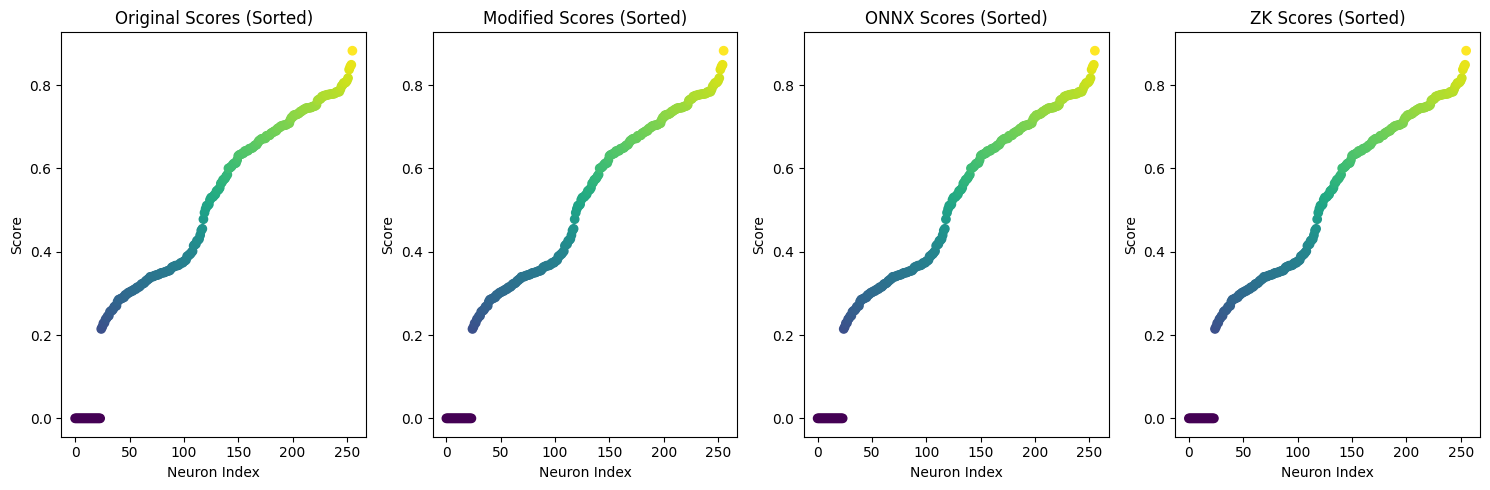


Score Statistics:
Original - Min: 0.000000, Max: 0.882305, Mean: 0.492111
Modified - Min: 0.000000, Max: 0.882305, Mean: 0.492111
ONNX     - Min: 0.000000, Max: 0.882305, Mean: 0.492111
ZK       - Min: 0.000000, Max: 0.882393, Mean: 0.492159


In [ ]:
from rich.console import Console
from rich.table import Table
from typing import List, Dict, Any, Tuple
import matplotlib.pyplot as plt
import numpy as np


def create_score_table() -> Tuple[Table, List[Tuple[str, str, str]]]:
    table = Table(title="Score Comparison")
    columns = [
        ("UID", "right", "cyan"),
        ("Challenge Attempts", "right", "blue"),
        ("Challenge Successes", "right", "blue"),
        ("Last 20 Failed", "right", "blue"),
        ("Elapsed Time Avg", "right", "blue"),
        ("Difficulty Avg", "right", "blue"),
        ("Has Docker", "center", "blue"),
        ("Allocated", "center", "blue"),
        ("Penalized", "center", "blue"),
        ("Original Score", "right", "magenta"),
        ("Modified Score", "right", "green"),
        ("ZK Score", "right", "yellow"),
        ("Modified Diff", "right", "red"),
        ("ZK Diff", "right", "red")
    ]
    return table, columns


def calculate_differences(orig: float, mod: float, zk: float) -> Tuple[float, float, str, str]:
    mod_diff = np.abs(np.float32(mod) - np.float32(orig))
    zk_diff = np.abs(np.float32(zk) - np.float32(orig))
    mod_color = "red" if mod_diff > 1e-4 else "green"
    zk_color = "red" if zk_diff > 1e-4 else "green"
    return mod_diff, zk_diff, mod_color, zk_color


def format_row_data(i: int, input_data: Dict, orig: float, mod: float, zk: float,
                   mod_color: str, zk_color: str, mod_diff: float, zk_diff: float) -> List[str]:
    return [
        f"{i}",
        f"{input_data.response['challenge_attempts']}",
        f"{input_data.response['challenge_successes']}",
        f"{input_data.response['last_20_challenge_failed']}",
        f"{input_data.response['challenge_elapsed_time_avg']:.4f}",
        f"{input_data.response['last_20_difficulty_avg']:.4f}",
        "✓" if input_data.response["has_docker"] else "✗",
        "✓" if input_data.hotkey in input_data.allocated_hotkeys else "✗",
        "✓" if input_data.hotkey in input_data.penalized_hotkeys else "✗",
        f"{orig:.6f}",
        f"{mod:.6f}",
        f"{zk:.6f}",
        f"[{mod_color}]{mod_diff:+.6f}[/{mod_color}]",
        f"[{zk_color}]{zk_diff:+.6f}[/{zk_color}]"
    ]


def plot_scores(scores: List[float], ax: plt.Axes, title: str):
    sorted_scores = sorted(scores)
    ax.scatter(range(len(sorted_scores)), sorted_scores, c=sorted_scores, cmap="viridis")
    ax.set_xlabel("Neuron Index")
    ax.set_ylabel("Score")
    ax.set_title(title)


def print_score_stats(scores: List[float], prefix: str):
    print(f"{prefix:<8} - Min: {min(scores):.6f}, Max: {max(scores):.6f}, "
          f"Mean: {sum(scores)/len(scores):.6f}")


def compare_all_scores(inputs: List[Dict[str, Any]], original_scores: List[float],
                      modified_scores: List[float], zk_scores: List[float],
                      onnx_scores: List[float] = None) -> None:
    table, columns = create_score_table()

    if onnx_scores is not None:
        columns.extend([("ONNX Score", "right", "cyan"), ("ONNX Diff", "right", "red")])

    for col, justify, style in columns:
        table.add_column(col, justify=justify, style=style)

    mod_red_count = zk_red_count = 0
    onnx_red_count = 0 if onnx_scores else None
    mod_total_diff = zk_total_diff = 0.0
    onnx_total_diff = 0.0 if onnx_scores else None

    for i, (input_data, orig, mod, zk) in enumerate(zip(inputs, original_scores, modified_scores, zk_scores)):
        mod_diff, zk_diff, mod_color, zk_color = calculate_differences(orig, mod, zk)
        mod_total_diff += mod_diff
        zk_total_diff += zk_diff
        mod_red_count += mod_color == "red"
        zk_red_count += zk_color == "red"

        row = format_row_data(i, input_data, orig, mod, zk, mod_color, zk_color, mod_diff, zk_diff)

        if onnx_scores is not None:
            onnx = onnx_scores[i]
            onnx_diff = np.abs(np.float32(onnx) - np.float32(orig))
            onnx_total_diff += onnx_diff
            onnx_color = "red" if onnx_diff > 1e-6 else "green"
            onnx_red_count += onnx_color == "red"
            row.extend([f"{onnx:.6f}", f"[{onnx_color}]{onnx_diff:+.6f}[/{onnx_color}]"])

        table.add_row(*row)

    total_count = len(original_scores)
    mod_red_percentage = (mod_red_count / total_count) * 100
    zk_red_percentage = (zk_red_count / total_count) * 100
    mod_avg_diff = mod_total_diff / total_count
    zk_avg_diff = zk_total_diff / total_count

    table.add_row("", "", "", "", "", "", "", "", "", "", "", "", "", "")
    if onnx_scores is not None:
        table.add_row("", "", "", "", "", "", "", "", "", "", "", "", "", "")
        onnx_red_percentage = (onnx_red_count / total_count) * 100
        onnx_avg_diff = onnx_total_diff / total_count
        table.add_row("", "", "", "", "", "", "", "", "", "", "High Loss %:", "", "",
                     f"[red]{mod_red_percentage:.2f}%[/red]",
                     f"[red]{zk_red_percentage:.2f}%[/red]",
                     f"[red]{onnx_red_percentage:.2f}%[/red]")
        table.add_row("", "", "", "", "", "", "", "", "", "", "Avg Difference:", "", "",
                     f"[yellow]{mod_avg_diff:.6f}[/yellow]",
                     f"[yellow]{zk_avg_diff:.6f}[/yellow]",
                     f"[yellow]{onnx_avg_diff:.6f}[/yellow]")
    else:
        table.add_row("", "", "", "", "", "", "", "", "", "", "High Loss %:", "", "",
                     f"[red]{mod_red_percentage:.2f}%[/red]",
                     f"[red]{zk_red_percentage:.2f}%[/red]")
        table.add_row("", "", "", "", "", "", "", "", "", "", "Avg Difference:", "", "",
                     f"[yellow]{mod_avg_diff:.6f}[/yellow]",
                     f"[yellow]{zk_avg_diff:.6f}[/yellow]")

    console = Console()
    console.width = 180
    console.print(table)


compare_all_scores(inputs, original_scores, modified_scores, zk_scores, onnx_scores)

if onnx_scores is not None:
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(15, 5))
else:
    fig, (ax0, ax1, ax3) = plt.subplots(1, 3, figsize=(15, 5))

plot_scores(original_scores, ax0, "Original Scores (Sorted)")
plot_scores(modified_scores, ax1, "Modified Scores (Sorted)")

if onnx_scores is not None:
    plot_scores(onnx_scores, ax2, "ONNX Scores (Sorted)")

plot_scores(zk_scores, ax3, "ZK Scores (Sorted)")

plt.tight_layout()
plt.show()

print("\nScore Statistics:")
print_score_stats(original_scores, "Original")
print_score_stats(modified_scores, "Modified")
if onnx_scores is not None:
    print_score_stats(onnx_scores, "ONNX")
print_score_stats(zk_scores, "ZK")